<a href="https://colab.research.google.com/github/cmt5270/Fellowship/blob/main/Recreating_Practice_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Install packages



In [19]:
install.packages(c("tidyverse", "lubridate", "janitor", "viridis"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [20]:
library(tidyverse)
library(lubridate)
library(janitor)
library(viridis)

# Step 2: Import Data



In [21]:
csv_path <- "/content/spending_test.csv"
spend <- read_csv(csv_path) |>
  clean_names() |>
  mutate(date = as_date(date))

Rows: 273 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): transaction_id
dbl  (2): individual_id, amount
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [22]:
glimpse(spend)

Rows: 273
Columns: 4
$ individual_id  <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ date           <date> 2025-01-06, 2025-01-07, 2025-01-08, 2025-01-09, 2025-0…
$ transaction_id <chr> "0_0_0", "0_1_0", "0_2_0", "0_3_0", "0_4_0", "0_5_0", "…
$ amount         <dbl> 139.48, 88.69, 110.36, 93.68, 43.91, 124.22, 130.69, 66…


In [23]:
head(spend)

individual_id,date,transaction_id,amount
<dbl>,<date>,<chr>,<dbl>
0,2025-01-06,0_0_0,139.48
0,2025-01-07,0_1_0,88.69
0,2025-01-08,0_2_0,110.36
0,2025-01-09,0_3_0,93.68
0,2025-01-10,0_4_0,43.91
0,2025-01-11,0_5_0,124.22


# Step 3: Feature Engineering

In [24]:
# 1) Compute total amount spent per person per day

daily <- spend |>
  group_by(individual_id, date) |>
  summarise(daily_total = sum(amount), .groups = "drop")

head(daily)
tail(daily)

## yields total amount spent by each person per day, ordered by person

individual_id,date,daily_total
<dbl>,<date>,<dbl>
0,2025-01-06,139.48
0,2025-01-07,88.69
0,2025-01-08,110.36
0,2025-01-09,93.68
0,2025-01-10,43.91
0,2025-01-11,124.22


individual_id,date,daily_total
<dbl>,<date>,<dbl>
24,2025-01-07,58.14
24,2025-01-08,19.39
24,2025-01-09,50.55
24,2025-01-10,87.09
24,2025-01-11,49.74
24,2025-01-12,20.38


In [25]:
# SIDE QUEST: Experimentation with variable order
daily_person_spend <- spend |>
  group_by(date, individual_id) |>
  summarise(total_per_date = sum(amount), .groups = "drop")

head(daily_person_spend)

## when using summarise after group_by, keeps first variable listed in group_by function
## also yields amount spent by each person per day, but ordered by date instead of person

date,individual_id,total_per_date
<date>,<dbl>,<dbl>
2025-01-06,0,139.48
2025-01-06,1,150.46
2025-01-06,2,130.48
2025-01-06,3,147.62
2025-01-06,4,135.01
2025-01-06,5,72.15


In [26]:
# 2) Compute per-person statistics

## Compute per-person summary statistics
person_stats <- daily |>
  group_by(individual_id) |>
  summarize(
    avg_daily = mean(daily_total, na.rm = TRUE), # average amount spent by each person on a daily basis
    max_daily = max(daily_total, na.rm = TRUE), # most spent on any given day for each person
    day_count = n(), # the number of days each person exhibited spending (should be 7)
    .groups = "drop"
  )

## Compute total number of transactions and largest single amt spent per person
  txn_features <- spend |>
    group_by(individual_id) |>
    summarise(
      txn_count = n(), # total number of transactions for each person
      max_transaction = max(amount, na.rm = TRUE), # single largest transaction per person
      .groups = "drop"
    )

## Create new data frame containing all generated stats
features <- person_stats |>
    left_join(txn_features, by = "individual_id") # combines txn_count and max_transaction with summary stats per person

glimpse(features)
head(features)

Rows: 25
Columns: 6
$ individual_id   <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …
$ avg_daily       <dbl> 104.43286, 99.44571, 130.16714, 202.45429, 219.30429, …
$ max_daily       <dbl> 139.48, 213.77, 328.00, 372.50, 470.01, 205.53, 101.51…
$ day_count       <int> 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, …
$ txn_count       <int> 7, 14, 11, 7, 10, 13, 13, 7, 13, 13, 8, 10, 13, 12, 7,…
$ max_transaction <dbl> 139.48, 83.49, 235.33, 372.50, 412.37, 112.53, 81.38, …


individual_id,avg_daily,max_daily,day_count,txn_count,max_transaction
<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
0,104.43286,139.48,7,7,139.48
1,99.44571,213.77,7,14,83.49
2,130.16714,328.00,7,11,235.33
3,202.45429,372.50,7,7,372.50
4,219.30429,470.01,7,10,412.37
5,58.02429,205.53,7,13,112.53


### Other Notes
- na.rm = remove any NA values.
  - prevents missing data from affecting calculations
- n() = "give me the number of rows in this current group."
  - is a special dplyr operation that returns the number of rows in the current group.
  - counts rows, not values in a specific column
  - must be run within other operators like summarize or mutate AFTER grouping

# Step 4: Visualize

Examine each person's average daily spending and max transaction size for patterns..

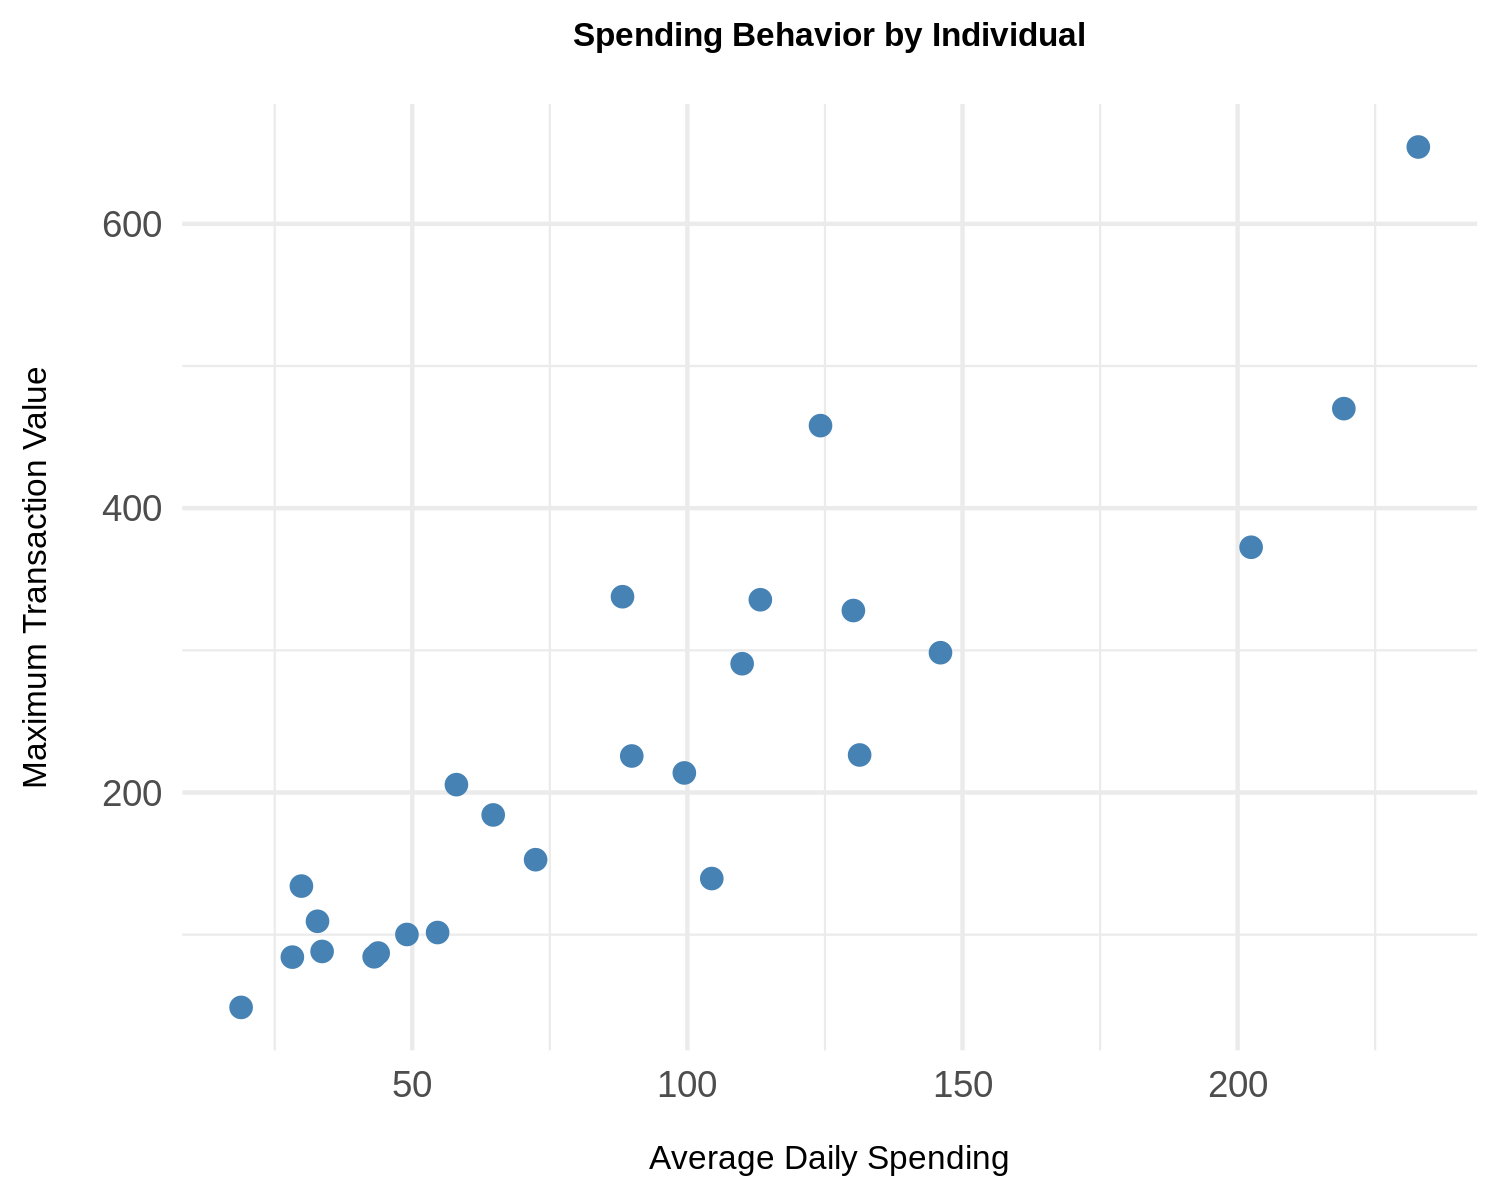

In [27]:
# Basic scatter plot
options(repr.plot.width=5, repr.plot.height=4, repr.plot.res = 300)
features |>
  ggplot(aes(x = avg_daily, y = max_daily)) +
  geom_point(alpha = 1, color = "steelblue", size = 2) +
  labs(
    title = "Spending Behavior by Individual",
    x = "Average Daily Spending",
    y = "Maximum Transaction Value") +
  theme_minimal() +
  theme(plot.title = element_text(face = 'bold', hjust = 0.5, margin = margin(b = 12), size = 8),
        axis.title.x = element_text(margin = margin(t = 10), size = 8),
        axis.title.y = element_text(margin = margin(r = 10), size = 8))

##Compute spending terciles

      33%       67% 
 54.15714 110.21611 
    33%     80% 
132.190 336.008 


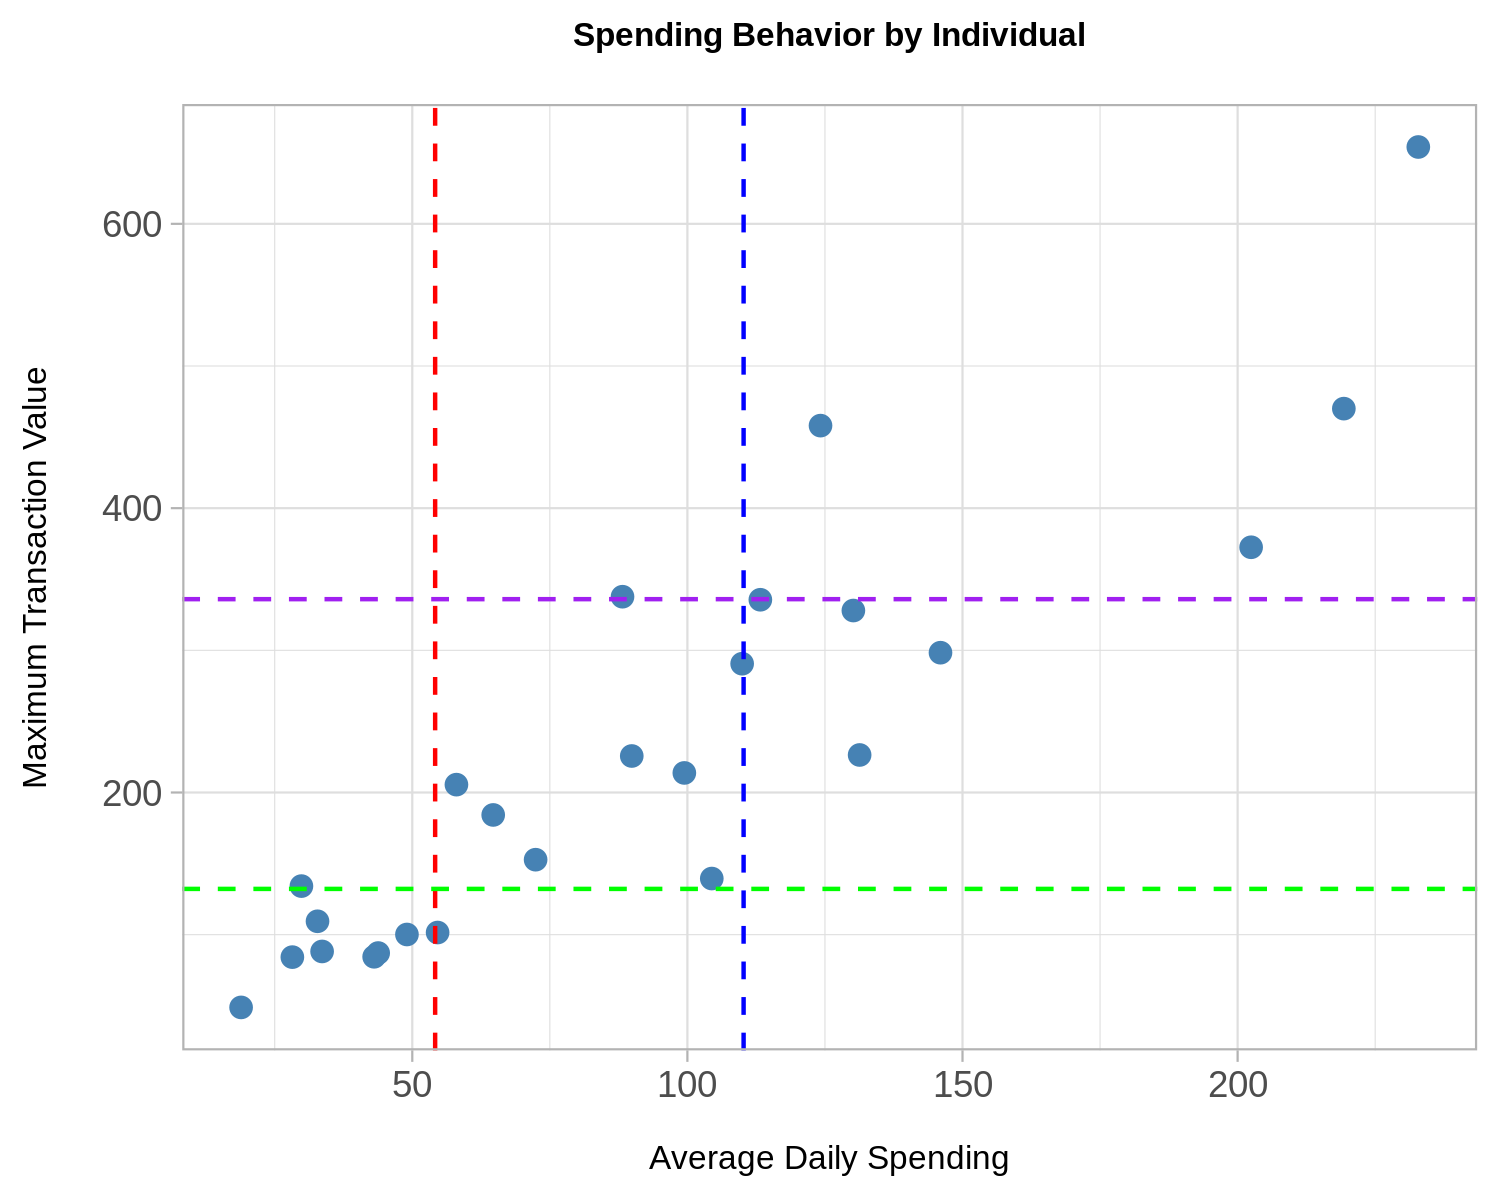

In [28]:
# Calculate percentile cutoffs for average daily spending
t_avg <- quantile(features$avg_daily,
                  probs = c(0.33, 0.67),
                  na.rm = TRUE)
print(t_avg)

# Compute percentile cutoffs for maximum daily spending
t_max <- quantile(features$max_daily,
                  probs = c(0.33, 0.80),
                  na.rm = TRUE)
print(t_max)

# ecreate scatter plot but with percentiles
features |>
  ggplot(aes(x = avg_daily, y = max_daily)) +
  geom_point(alpha = 1, color = "steelblue", size = 2) +
   geom_vline(xintercept = t_avg,
             linetype = "dashed",
             color    = c("red", "blue")) +
  geom_hline(yintercept = t_max,
             linetype = "dashed",
             color    = c("green", "purple")) +
  labs(
    title = "Spending Behavior by Individual",
    x = "Average Daily Spending",
    y = "Maximum Transaction Value") +
  theme_light() +
  theme(plot.title = element_text(face = 'bold', hjust = 0.5, margin = margin(b = 12), size = 8),
        axis.title.x = element_text(margin = margin(t = 10), size = 8),
        axis.title.y = element_text(margin = margin(r = 10), size = 8))

### Other Notes
- quantile() calculates quantile cut offs for a given numeric variable


## Color-coded heuristic

income_group,n
<chr>,<int>
high_income,9
low_income,7
middle_income,9


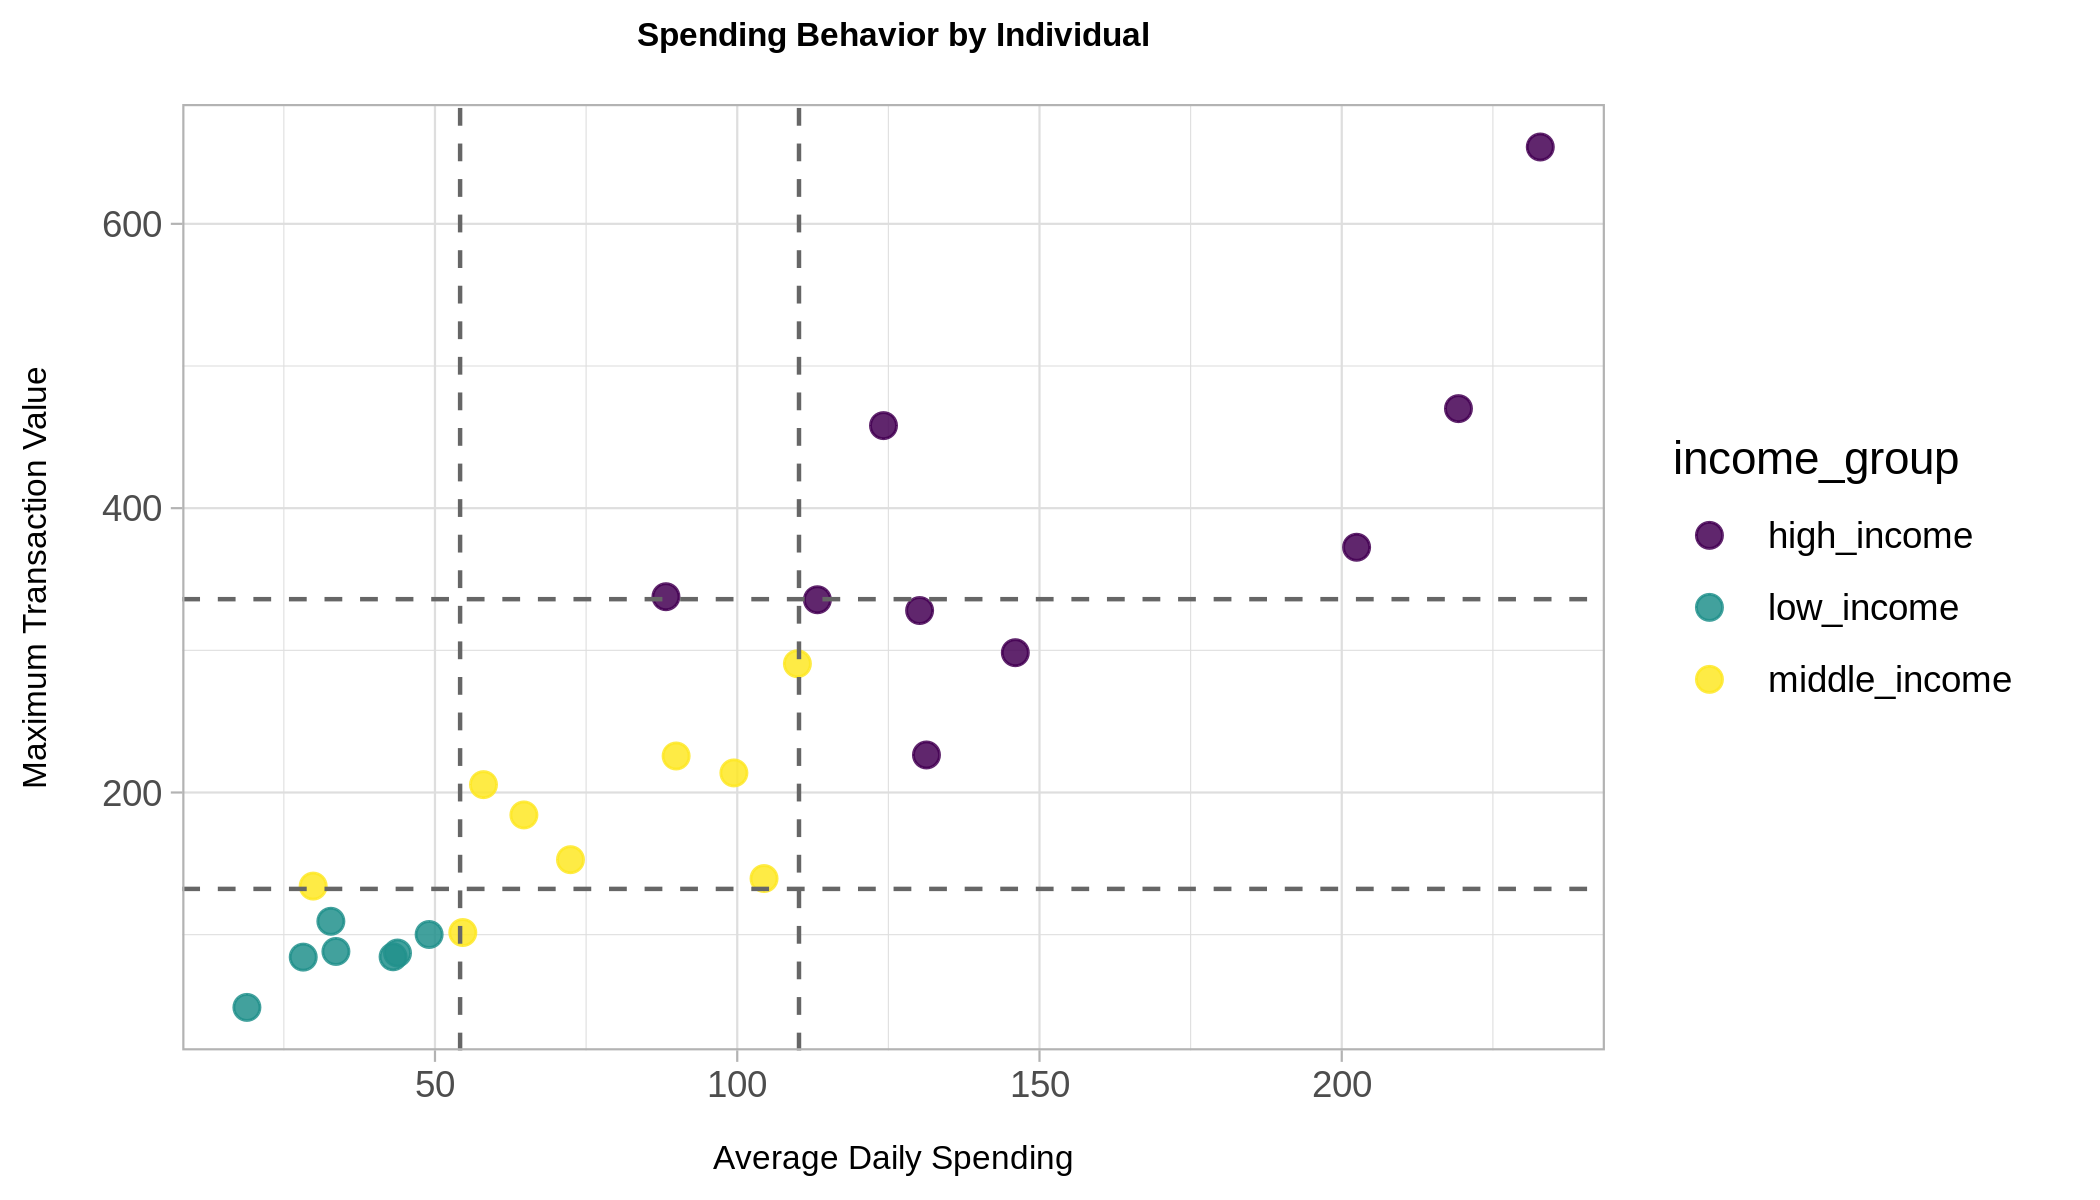

In [36]:
# Rename percentiles for readability
avg_33 <- t_avg[[1]]
avg_67 <- t_avg[[2]]
max_33 <- t_max[[1]]
max_80 <- t_max[[2]]

# Create color-coded income groupings
feature_plot <- features |>
  mutate(
    income_group = case_when(
      avg_daily <= avg_33 & max_daily <= max_33 ~ "low_income",
      avg_daily >= avg_67 | max_daily >= max_80 ~ "high_income",
      TRUE ~ "middle_income"))

# Spot check number of individuals in each grouping
feature_plot |>
  count(income_group)

# Plot color-coded heuristic
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res = 300)
feature_plot |>
  ggplot(aes(x = avg_daily, y = max_daily, color = income_group)) +
  geom_point(alpha = 0.85, size = 2.6) +
  geom_vline(xintercept = c(avg_33, avg_67),
             linetype = "dashed", color = "grey40") +
  geom_hline(yintercept = c(max_33, max_80),
             linetype = "dashed", color = "grey40") +
  scale_color_viridis_d(option = "D")+
  labs(
    title = "Spending Behavior by Individual",
    x = "Average Daily Spending",
    y = "Maximum Transaction Value") +
  theme_light() +
  theme(plot.title = element_text(face = 'bold', hjust = 0.5,
          margin = margin(b = 12), size = 8),
        axis.title.x = element_text(margin = margin(t = 10), size = 8),
        axis.title.y = element_text(margin = margin(r = 10), size = 8))

### Other notes
**`mutate()` adds/modifies columns in the data frame**

**`case-when()` chooses values based on multiple conditions**
  - like multiple if/else statements
  - determines what goes in each row in new column created by mutate function
  - uses & = AND, | = OR
  - defines specific conditions (in this example, high or low-income) and TRUE captures everything else
    - if don't add something for 'TRUE' then everything else gets left out
  - ~ is used to assign names to new cateogries in the new vairable

**other options when using mutate function:** `ifelse()` or simple calculations


*`mutate(ifelse(test_score >= 75, pass, fail))`*
- translates to "If an individual's score is greater than or equal to 75, they pass; if not they fail.
- Assigns true condition to first variable

*`mutate(double = x * 2)`*
- translates to "Any value x multiplied by 2 always means double"
- used for simple numeric classification



